<a href="https://colab.research.google.com/github/tharushaliyanagama/OralCancerEarlyDetection-DSGP/blob/Prediction-of-textual-data-I/Text_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Dataset Analysis***

**1. Import Libraries**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle

**2. Load and Inspect the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DSGP/DatasetNewII_risk.csv')

In [ ]:
#Display information
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   public_id            2237 non-null   int64  
 1   lesion_id            2237 non-null   int64  
 2   patient_id           2237 non-null   int64  
 3   localization         2237 non-null   object 
 4   larger_size          2237 non-null   float64
 5   tobacco_use          2237 non-null   object 
 6   alcohol_consumption  2237 non-null   object 
 7   sun_exposure         2237 non-null   object 
 8   gender               2237 non-null   object 
 9   skin_color           2237 non-null   object 
 10  age                  2237 non-null   int64  
 11  risk_level           2237 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 209.8+ KB
None


In [ ]:
#Load 5 rows
print("\nFirst 5 rows:")
print(data.head())


First 5 rows:
   public_id  lesion_id  patient_id localization  larger_size tobacco_use  \
0          0         50          48       Tongue          2.0         Yes   
1          1         50          48       Tongue          2.0         Yes   
2          2         41          39       Tongue          2.5         Yes   
3          3         41          39       Tongue          2.5         Yes   
4          4         87          81          Lip          1.5      Former   

  alcohol_consumption sun_exposure gender skin_color  age   risk_level  
0                  No           No      M      Black   76  Medium Risk  
1                  No           No      M      Black   86  Medium Risk  
2              Former          Yes      M      White   36  Medium Risk  
3              Former          Yes      M      White   32  Medium Risk  
4                 Yes          Yes      F      White   31  Medium Risk  


**3. Understand Numerical Features**

In [ ]:
# Remove unnecessary features based on correlation and domain knowledge
columns_to_drop = ['patient_id', 'public_id', 'lesion_id']  # Irrelevant for prediction
print(f"\nDropping columns: {columns_to_drop}")
data = data.drop(columns=columns_to_drop)


Dropping columns: ['patient_id', 'public_id', 'lesion_id']


In [ ]:
# Select numeric variables
numeric_columns = data.select_dtypes(include=['int64', 'float64'])

# Print numeric variables
print("Numeric Variables:")
print(numeric_columns.head())

Numeric Variables:
   larger_size  age
0          2.0   76
1          2.0   86
2          2.5   36
3          2.5   32
4          1.5   31


**4. Histograms for Numerical Features**

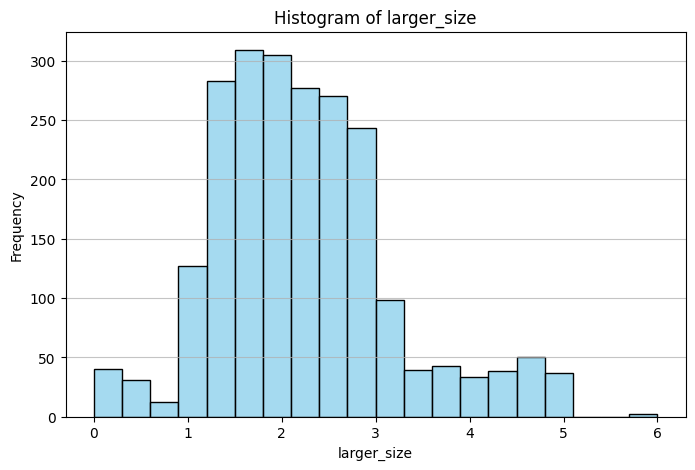

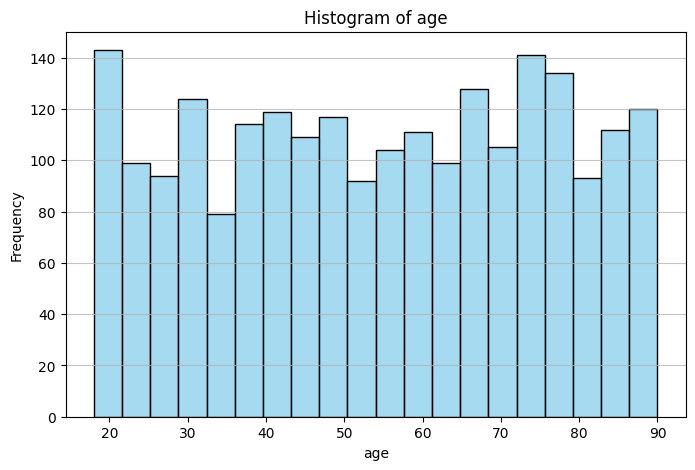

In [ ]:
# Plot histograms for specific numerical variables
for column in ['larger_size', 'age']:
    if column in data.select_dtypes(include=['number']).columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(data, x=column, bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.grid(axis='y', alpha=0.75)
        plt.show()


**5. Box Plot to Identify Outliers**

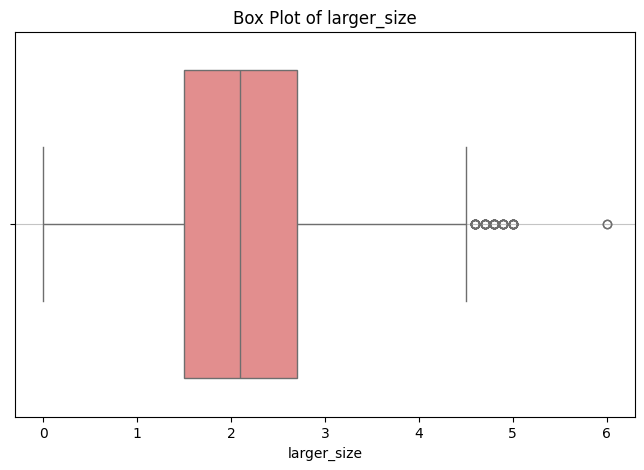

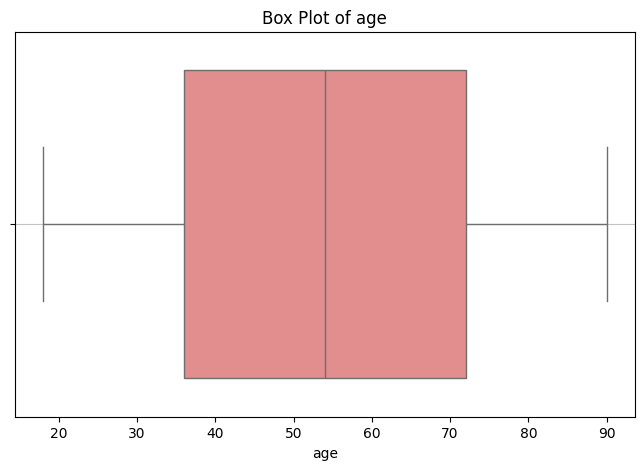

In [ ]:
# Plot box plots for specific numerical variables to identify outliers
for column in ['larger_size', 'age']:
    if column in data.select_dtypes(include=['number']).columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=data, x=column, color='lightcoral')
        plt.title(f"Box Plot of {column}")
        plt.xlabel(column)
        plt.grid(axis='y', alpha=0.75)
        plt.show()

**6. Handle Outliers using IQR method**

In [ ]:
# Calculate the IQR for the 'larger_size' column
Q1 = data['larger_size'].quantile(0.25)  # 25th percentile
Q3 = data['larger_size'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to exclude outliers
filtered_data = data[(data['larger_size'] >= lower_bound) & (data['larger_size'] <= upper_bound)]

# Display the number of rows removed
removed_rows = len(data) - len(filtered_data)
print(f"Outliers removed: {len(data)} remaining rows")
print(f"Number of rows removed: {removed_rows}")

Outliers removed: 2237 remaining rows
Number of rows removed: 67


**7. Understand Categorical Features**

In [ ]:
# Select categorical variables
categorical_columns = data.select_dtypes(include=['object'])

# Print categorical variables
print("Categorical Variables:")
print(categorical_columns.head())

Categorical Variables:
  localization tobacco_use alcohol_consumption sun_exposure gender skin_color  \
0       Tongue         Yes                  No           No      M      Black   
1       Tongue         Yes                  No           No      M      Black   
2       Tongue         Yes              Former          Yes      M      White   
3       Tongue         Yes              Former          Yes      M      White   
4          Lip      Former                 Yes          Yes      F      White   

    risk_level  
0  Medium Risk  
1  Medium Risk  
2  Medium Risk  
3  Medium Risk  
4  Medium Risk  


**8. Unique values of each column**

In [ ]:
# Encode categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if column != 'risk_level':
        print(f"Column: {column}")
        print(f"Unique values before encoding: {data[column].unique()}")

        # Apply LabelEncoder
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])

        print(f"Unique values after encoding: {data[column].unique()}")
        print("-")

# Encode 'age' into groups
def age_group(age):
    if age < 40:
        return 0
    elif 40 <= age <= 60:
        return 1
    else:
        return 2

data['age'] = data['age'].apply(age_group)

print("\nEncoding Criteria for 'age': ['age > 60' → 0, '40 <= age <= 60' → 1, 'age < 40' → 2]")
print("Unique values of 'age' after encoding:", data['age'].unique())

Column: localization
Unique values before encoding: ['Tongue' 'Lip' 'Floor of mouth' 'Buccal mucosa' 'Palate' 'Gingiva'
 'Cheek' 'Gum' 'Buccal Mucosa']
Unique values after encoding: [8 6 3 1 7 4 2 5 0]
-
Column: tobacco_use
Unique values before encoding: ['Yes' 'Former' 'No' 'Not informed']
Unique values after encoding: [3 0 1 2]
-
Column: alcohol_consumption
Unique values before encoding: ['No' 'Former' 'Yes' 'Not informed']
Unique values after encoding: [1 0 3 2]
-
Column: sun_exposure
Unique values before encoding: ['No' 'Yes' 'Not informed']
Unique values after encoding: [0 2 1]
-
Column: gender
Unique values before encoding: ['M' 'F']
Unique values after encoding: [1 0]
-
Column: skin_color
Unique values before encoding: ['Black' 'White' 'Not informed' 'Brown' 'Asian' 'Hispanic']
Unique values after encoding: [1 5 4 2 0 3]
-

Encoding Criteria for 'age': ['age > 60' → 0, '40 <= age <= 60' → 1, 'age < 40' → 2]
Unique values of 'age' after encoding: [2 0 1]


# **Data Cleaning**

**9. Handle Missing Values**

In [ ]:
# Check for missing values
print("\nChecking for missing values:")
print(data.isnull().sum())


Checking for missing values:
localization           0
larger_size            0
tobacco_use            0
alcohol_consumption    0
sun_exposure           0
gender                 0
skin_color             0
age                    0
risk_level             0
dtype: int64


**10. Handle Duplicate Values**

In [ ]:
# Check for duplicate rows
print(f"\nNumber of duplicate rows before removal: {data.duplicated().sum()}")


Number of duplicate rows before removal: 113


# **Feature Engineering**

**11. Label Encoding**

**12. Map Target Variable**

In [ ]:
# Map risk levels to numerical categories
data['risk_level'] = data['risk_level'].map({'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2})

In [ ]:
# Force data type conversion
data['risk_level'] = pd.to_numeric(data['risk_level'])

**13. Check Imbalacing of Dataset**

In [ ]:
#Analyze Target Imbalance
target_column = 'risk_level'
print("\nTarget value distribution:")
print(data[target_column].value_counts())


Target value distribution:
risk_level
1    2104
0     100
2      33
Name: count, dtype: int64


<Axes: xlabel='risk_level'>

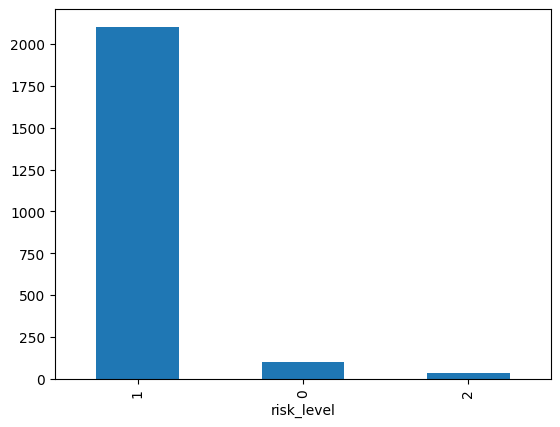

In [ ]:
#Plot Imbalance dataset
data[target_column].value_counts().plot(kind='bar')

**14. Handle Imbalancing Uning SMOTE**

In [ ]:
# Handle class imbalance using SMOTE
X = data.drop(columns=[target_column])
y = data[target_column]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
risk_level
1    2104
0    2104
2    2104
Name: count, dtype: int64


<Axes: xlabel='risk_level'>

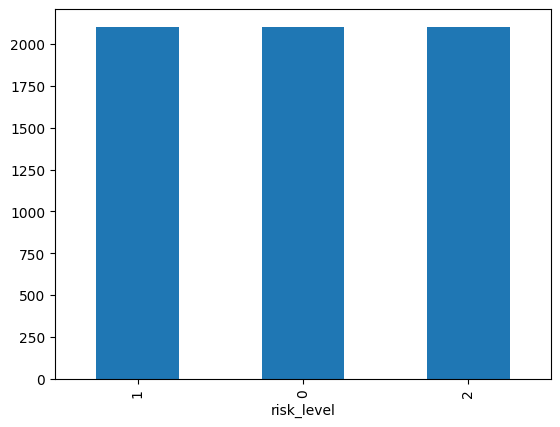

In [ ]:
 #Plot the balace dataset
 pd.Series(y_resampled).value_counts().plot(kind='bar')

**15. Correlation Analysis**

In [ ]:
print("\nCorrelation Analysis:")
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['risk_level'].sort_values(ascending=False)
print(correlation_with_target)


Correlation Analysis:
risk_level             1.000000
age                    0.214166
sun_exposure           0.173942
localization           0.153007
tobacco_use            0.142543
larger_size            0.140687
alcohol_consumption    0.127380
skin_color             0.080333
gender                 0.045322
Name: risk_level, dtype: float64


**16. Visualization of Correlation values**

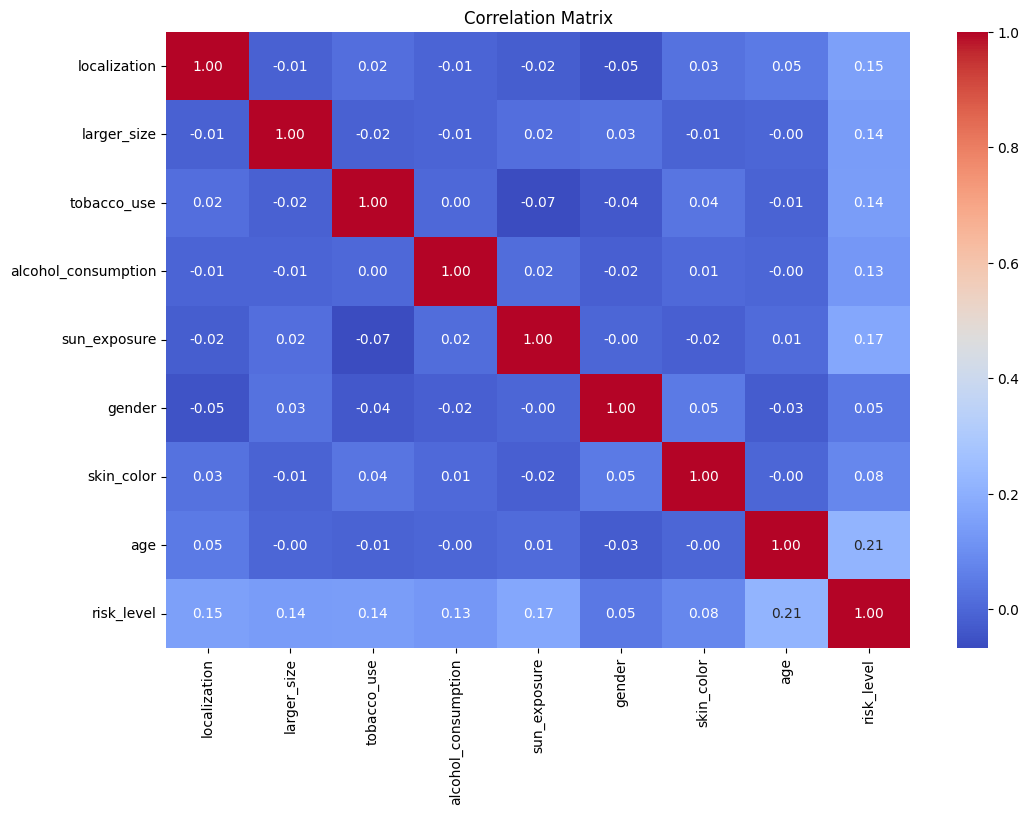

In [ ]:
# Visualize correlation with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

**17. Features Selection**

**18. Dataset Splitting**

In [ ]:
# Print remaining features
print("\nRemaining features after dropping unnecessary columns:")
print(list(data.columns))


Remaining features after dropping unnecessary columns:
['localization', 'larger_size', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color', 'age', 'risk_level']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 4418
Test set size: 1894


In [ ]:
# Save feature names before scaling (to maintain correct order)
feature_names = X_train.columns.tolist()
print(feature_names)
with open('feature_names.pkl', 'wb') as file:
    pickle.dump(feature_names, file)

['localization', 'larger_size', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color', 'age']


**19. Feature Scaling**

In [ ]:
# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler to use during predictions
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Data preprocessing completed.")

Data preprocessing completed.


# **SVM Model Training**

In [ ]:
import pickle
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.model_selection import GridSearchCV

# Load saved feature names
with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)

# Define SVR Hyperparameter Grid
param_grid_svr = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize SVR Model
svr_model = SVR()

# Perform Grid Search for Best Parameters
grid_search_svr = GridSearchCV(svr_model, param_grid_svr, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search_svr.fit(X_train_scaled, y_train)

# Retrieve Best SVR Model
best_svr = grid_search_svr.best_estimator_
print("\n✅ Best SVR Parameters:", grid_search_svr.best_params_)

# Predict on Test Data
y_pred_svr = best_svr.predict(X_test_scaled)

print("\n🔹 SVR Regression Metrics on Test Data:")
print(f"   🔹 Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_svr):.4f}")
print(f"   🔹 R-squared Score (R²): {r2_score(y_test, y_pred_svr):.4f}")

# Predict on Training Data
y_train_pred_svr = best_svr.predict(X_train_scaled)

print("\n🔹 SVR Regression Metrics on Training Data:")
print(f"   🔹 Mean Squared Error (MSE): {mean_squared_error(y_train, y_train_pred_svr):.4f}")
print(f"   🔹 R-squared Score (R²): {r2_score(y_train, y_train_pred_svr):.4f}")

# Convert Regression Predictions to Categories (Ordinal Classification)
def categorize_predictions(y_pred):
    return np.round(y_pred).astype(int)  # Rounding to nearest integer (assuming labels 0,1,2)

y_test_class = categorize_predictions(y_pred_svr)
y_train_class = categorize_predictions(y_train_pred_svr)

# Classification Reports
print("\n🔹 SVR Classification Report on Test Data:")
print(classification_report(y_test, y_test_class))

print("\n🔹 SVR Classification Report on Training Data:")
print(classification_report(y_train, y_train_class))

# Save the trained SVR model
with open('svr_model.pkl', 'wb') as file:
    pickle.dump(best_svr, file)

print("\n✅ SVR model saved as 'svr_model.pkl'.")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Best SVR Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

🔹 SVR Regression Metrics on Test Data:
   🔹 Mean Squared Error (MSE): 0.0277
   🔹 R-squared Score (R²): 0.9580

🔹 SVR Regression Metrics on Training Data:
   🔹 Mean Squared Error (MSE): 0.0162
   🔹 R-squared Score (R²): 0.9758

🔹 SVR Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       631
           1       0.99      0.93      0.96       643
           2       0.98      1.00      0.99       620

    accuracy                           0.97      1894
   macro avg       0.97      0.97      0.97      1894
weighted avg       0.97      0.97      0.97      1894


🔹 SVR Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1473
           1       1.00      0.96      0.98      1461
         

In [ ]:
pip install tensorflow scikit-learn numpy matplotlib

In [ ]:
pip install tensorflow

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7215 - loss: 0.7289 - val_accuracy: 0.9480 - val_loss: 0.1675
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9019 - loss: 0.2561 - val_accuracy: 0.9615 - val_loss: 0.1215
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9356 - loss: 0.1818 - val_accuracy: 0.9661 - val_loss: 0.1031
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9499 - loss: 0.1491 - val_accuracy: 0.9729 - val_loss: 0.0797
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9536 - loss: 0.1420 - val_accuracy: 0.9796 - val_loss: 0.0718
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9601 - loss: 0.1262 - val_accuracy: 0.9774 - val_loss: 0.0687
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9664 - loss: 0.1017 - val_accuracy: 0.9774 - val_loss: 0.0685
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9614 - loss: 0.1113 - val_a

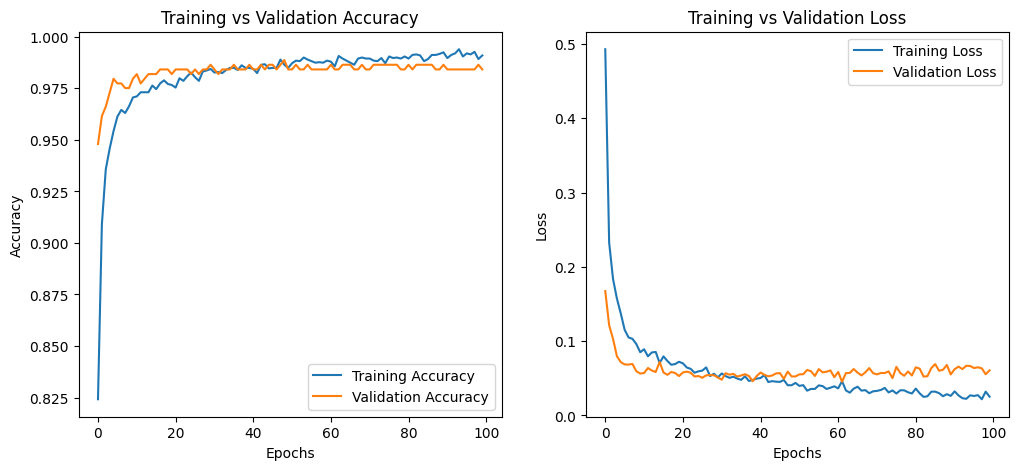


✅ Neural Network model saved as 'nn_model.h5'.


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Load saved feature names
with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)

# Prepare the data (Ensure X_train_scaled, X_test_scaled, y_train, y_test are preprocessed)
num_classes = len(np.unique(y_train))
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

# Build the Neural Network model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Increased neurons
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate for stability
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_onehot,
                    validation_split=0.1,
                    epochs=100,  # Increased epochs for better training
                    batch_size=32,
                    verbose=1)

# Evaluate the model on the test data
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train_onehot, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)

print(f"\n🔹 Training Accuracy: {train_accuracy:.2f}")
print(f"🔹 Test Accuracy: {test_accuracy:.2f}")

# Make predictions
y_prob_nn = model.predict(X_test_scaled)
y_pred_nn = np.argmax(y_prob_nn, axis=1)

# Classification report and ROC-AUC score
print("\n🔹 Neural Network Classification Report on Test Data:")
print(classification_report(y_test, y_pred_nn))
print(f"🔹 Neural Network ROC-AUC Score on Test Data: {roc_auc_score(y_test, y_prob_nn, multi_class='ovr'):.2f}")

# Classification report for training data
y_train_prob_nn = model.predict(X_train_scaled)
y_train_pred_nn = np.argmax(y_train_prob_nn, axis=1)

print("\n🔹 Neural Network Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_nn))
print(f"🔹 Neural Network ROC-AUC Score on Training Data: {roc_auc_score(y_train, y_train_prob_nn, multi_class='ovr'):.2f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

# Save the trained model
model.save('nn_model.h5')

print("\n✅ Neural Network model saved as 'nn_model.h5'.")

In [ ]:
import pickle
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report

# Load saved feature names
with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, learning_rate=0.1)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Predict on Test Data
y_pred_xgb = xgb_model.predict(X_test_scaled)

print("\n🔹 XGBoost Regression Metrics on Test Data:")
print(f"   🔹 Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_xgb):.4f}")
print(f"   🔹 R-squared Score (R²): {r2_score(y_test, y_pred_xgb):.4f}")

# Predict on Training Data
y_train_pred_xgb = xgb_model.predict(X_train_scaled)

print("\n🔹 XGBoost Regression Metrics on Training Data:")
print(f"   🔹 Mean Squared Error (MSE): {mean_squared_error(y_train, y_train_pred_xgb):.4f}")
print(f"   🔹 R-squared Score (R²): {r2_score(y_train, y_train_pred_xgb):.4f}")

# Convert Regression Predictions to Categories (Ordinal Classification)
def categorize_predictions(y_pred):
    return np.round(y_pred).astype(int)  # Rounding to nearest integer (assuming labels 0,1,2)

y_test_class = categorize_predictions(y_pred_xgb)
y_train_class = categorize_predictions(y_train_pred_xgb)

# Classification Reports
print("\n🔹 XGBoost Classification Report on Test Data:")
print(classification_report(y_test, y_test_class))

print("\n🔹 XGBoost Classification Report on Training Data:")
print(classification_report(y_train, y_train_class))

# Save the trained XGBoost model
with open('xgb_regressor.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

print("\n✅ XGBoost Regressor model saved as 'xgb_regressor.pkl'.")


🔹 XGBoost Regression Metrics on Test Data:
   🔹 Mean Squared Error (MSE): 0.0228
   🔹 R-squared Score (R²): 0.9655

🔹 XGBoost Regression Metrics on Training Data:
   🔹 Mean Squared Error (MSE): 0.0066
   🔹 R-squared Score (R²): 0.9902

🔹 XGBoost Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       631
           1       0.99      0.94      0.96       643
           2       0.97      1.00      0.98       620

    accuracy                           0.98      1894
   macro avg       0.98      0.98      0.98      1894
weighted avg       0.98      0.98      0.98      1894


🔹 XGBoost Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1473
           1       1.00      0.99      0.99      1461
           2       0.99      1.00      1.00      1484

    accuracy                           1.00      4418
   macro avg 

In [ ]:
pip install keras

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import load_model

with open('svr_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('xgb_regressor.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

# Load the scaler and feature names from training
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)  # Ensures correct feature order

# Define categorical and numerical features
categorical_features = ['localization', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color']
numerical_features = ['larger_size', 'age_group']

# Define LabelEncoders (Use mappings from training)
label_encoders = {
    'localization': LabelEncoder().fit(['Tongue', 'Lip', 'Floor of mouth', 'Buccal mucosa', 'Palate', 'Gingiva', 'Cheek', 'Gum', 'Buccal Mucosa']),
    'tobacco_use': LabelEncoder().fit(['Yes', 'Former', 'No', 'Not informed']),
    'alcohol_consumption': LabelEncoder().fit(['No', 'Former', 'Yes', 'Not informed']),
    'sun_exposure': LabelEncoder().fit(['No', 'Yes', 'Not informed']),
    'gender': LabelEncoder().fit(['M', 'F']),
    'skin_color': LabelEncoder().fit(['Black', 'White', 'Not informed', 'Brown', 'Asian', 'Hispanic']),
}

# Function to categorize age into groups
def categorize_age(age):
    """Categorize age into risk groups."""
    try:
        age = int(age)
        if age < 40:
            return 0
        elif 40 <= age <= 60:
            return 1
        else:
            return 2
    except ValueError:
        print("⚠️ Invalid input for age. Defaulting to group 1 (40-60 years).")
        return 1  # Default to medium age risk

# Function to get user input
def get_user_input():
    """Take user input for all required features and return a dictionary."""
    user_data = {}

    print("\n🔹 Enter values for the following features:")
    for feature in categorical_features + ['larger_size', 'age']:
        user_data[feature] = input(f"   {feature}: ").strip()

    return user_data

# Take user input
user_data = get_user_input()

# Convert age input to numeric and categorize it
user_data['age_group'] = categorize_age(user_data['age'])

# Convert input data into a DataFrame
input_df = pd.DataFrame([user_data])

# Apply Label Encoding to categorical features (ensuring consistency with training)
for feature in categorical_features:
    if user_data[feature] in label_encoders[feature].classes_:
        input_df[feature] = label_encoders[feature].transform([user_data[feature]])
    else:
        default_value = 'Not informed' if 'Not informed' in label_encoders[feature].classes_ else label_encoders[feature].classes_[0]
        print(f"⚠️ Warning: Unseen category '{user_data[feature]}' for {feature}. Using '{default_value}' as default.")
        input_df[feature] = label_encoders[feature].transform([default_value])

# Ensure numerical columns are correctly formatted
input_df[['larger_size', 'age_group']] = input_df[['larger_size', 'age_group']].astype(float)

# 🔹 **Ensure features are in the same order as training**
input_df = input_df.reindex(columns=feature_names, fill_value=0)  # Ensures correct feature order

# Standard Scaling (Use same scaler from training)
input_scaled = scaler.transform(input_df)

# 🔹 **Make predictions using all three models**
svm_prob = svm_model.predict(input_scaled)[0]
xgb_prob = xgb_model.predict(input_scaled)[0]

# Ensure probabilities are within bounds (0-1)
svm_prob = max(0, min(1, svm_prob))
xgb_prob = max(0, min(1, xgb_prob))

# 🔹 **Final Probability Calculation (Averaging Model Outputs)**
final_probability = (svm_prob + xgb_prob) / 2

# 🔹 Display results
print("\n🔹 Model Predictions for Oral Cancer Risk:")
print(f"   ⚡ SVM Probability: {svm_prob:.4f}")
print(f"   🚀 XGBoost Probability: {xgb_prob:.4f}")
print(f"   🎯 **Final Risk Probability: {final_probability:.4f}** (Scale: 0 to 1)")

# Interpretation based on probability thresholds
threshold_high = 0.7
threshold_medium = 0.4

if final_probability >= threshold_high:
    print("   🛑 **High Risk of Cancer Detected**")
elif final_probability >= threshold_medium:
    print("   ⚠️ **Medium Risk of Cancer Detected**")
else:
    print("   ✅ **Low Risk - No Cancer Detected**")


🔹 Enter values for the following features:
   localization: Lip
   tobacco_use: No
   alcohol_consumption: Yes
   sun_exposure: Yes
   gender: F
   skin_color: White
   larger_size: 0
   age: 30

🔹 Model Predictions for Oral Cancer Risk:
   ⚡ SVM Probability: 1.0000
   🚀 XGBoost Probability: 0.9620
   🎯 **Final Risk Probability: 0.9810** (Scale: 0 to 1)
   🛑 **High Risk of Cancer Detected**


In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the trained models
with open('nn_model.pkl', 'rb') as file:
    nn_model = pickle.load(file)

with open('svm_model_tuned.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

# Load the scaler and feature names from training
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)  # Ensure correct feature order

# Define categorical and numerical features
categorical_features = ['localization', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color']
numerical_features = ['larger_size', 'age_group']

# Define LabelEncoders (Use mappings from training)
label_encoders = {
    'localization': LabelEncoder().fit(['Tongue', 'Lip', 'Floor of mouth', 'Buccal mucosa', 'Palate', 'Gingiva', 'Cheek', 'Gum', 'Buccal Mucosa']),
    'tobacco_use': LabelEncoder().fit(['Yes', 'Former', 'No', 'Not informed']),
    'alcohol_consumption': LabelEncoder().fit(['No', 'Former', 'Yes', 'Not informed']),
    'sun_exposure': LabelEncoder().fit(['No', 'Yes', 'Not informed']),
    'gender': LabelEncoder().fit(['M', 'F']),
    'skin_color': LabelEncoder().fit(['Black', 'White', 'Not informed', 'Brown', 'Asian', 'Hispanic']),
}

# Function to categorize age into groups
def categorize_age(age):
    if age < 40:
        return 0
    elif 40 <= age <= 60:
        return 1
    else:
        return 2

# Function to get user input
def get_user_input():
    """Take user input for all required features and return a dictionary."""
    features = ['localization', 'larger_size', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color', 'age']
    user_data = {}

    print("\nEnter values for the following features:")
    for feature in features:
        user_data[feature] = input(f"{feature}: ").strip()

    return user_data

# Take user input
user_data = get_user_input()

# Convert age input to numeric and categorize it
user_data['age'] = int(user_data['age'])
user_data['age_group'] = categorize_age(user_data['age'])

# Convert input data into a DataFrame
input_df = pd.DataFrame([user_data])

# Apply Label Encoding to categorical features (ensure consistency with training)
for feature in categorical_features:
    if user_data[feature] in label_encoders[feature].classes_:
        input_df[feature] = label_encoders[feature].transform([user_data[feature]])
    else:
        print(f"⚠️ Warning: Unseen category '{user_data[feature]}' for {feature}. Using 'Not informed' as default.")
        input_df[feature] = label_encoders[feature].transform(['Not informed'])

# Ensure numerical columns are correctly formatted
input_df[['larger_size', 'age_group']] = input_df[['larger_size', 'age_group']].astype(float)

# 🔹 **Ensure features are in the same order as training**
input_df = input_df.reindex(columns=feature_names, fill_value=0)  # Ensures correct feature order

# Standard Scaling (Use same scaler from training)
input_scaled = scaler.transform(input_df)

# 🔹 **Make predictions using all three models**
nn_prob = nn_model.predict_proba(input_scaled)[:, 1]  # Probability of cancer
xgb_prob = xgb_model.predict_proba(input_scaled)[:, 1]

# 🔹 **Final Probability Calculation**
final_probability = (nn_prob + xgb_prob) / 2  # Averaging probabilities

# 🔹 Display results
print("\n🔹 Model Predictions for Oral Cancer Detection:")
print(f"   🧠 Neural Network Probability: {nn_prob[0]:.4f}")
print(f"   🚀 XGBoost Probability: {xgb_prob[0]:.4f}")

print(f"   🎯 {final_probability[0]:.4f} (Scale: 0 to 1)")

# Interpretation based on probability thresholds
threshold_high = 0.8
threshold_medium = 0.5

if final_probability[0] >= threshold_high:
    print("   🛑 **High Risk of Cancer Detected**")
elif final_probability[0] >= threshold_medium:
    print("   ⚠️ **Medium Risk of Cancer Detected**")
else:
    print("   ✅ **Low Risk - No Cancer Detected**")


Enter values for the following features:
localization: Gingiva
larger_size: 3
tobacco_use: No
alcohol_consumption: Yes
sun_exposure: No
gender: F
skin_color: Black
age: 25

🔹 Model Predictions for Oral Cancer Detection:
   🧠 Neural Network Probability: 0.0019
   🚀 XGBoost Probability: 0.9783
   🎯 0.4901 (Scale: 0 to 1)
   ✅ **Low Risk - No Cancer Detected**


In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the trained Neural Network model
with open('nn_model.pkl', 'rb') as file:
    nn_model = pickle.load(file)

# Load the scaler and feature names from training
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)  # Ensure correct feature order

# Define categorical and numerical features
categorical_features = ['localization', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color']
numerical_features = ['larger_size', 'age_group']

# Define LabelEncoders (Use mappings from training)
label_encoders = {
    'localization': LabelEncoder().fit(['Tongue', 'Lip', 'Floor of mouth', 'Buccal mucosa', 'Palate', 'Gingiva', 'Cheek', 'Gum', 'Buccal Mucosa']),
    'tobacco_use': LabelEncoder().fit(['Yes', 'Former', 'No', 'Not informed']),
    'alcohol_consumption': LabelEncoder().fit(['No', 'Former', 'Yes', 'Not informed']),
    'sun_exposure': LabelEncoder().fit(['No', 'Yes', 'Not informed']),
    'gender': LabelEncoder().fit(['M', 'F']),
    'skin_color': LabelEncoder().fit(['Black', 'White', 'Not informed', 'Brown', 'Asian', 'Hispanic']),
}

# Function to categorize age into groups
def categorize_age(age):
    if age < 40:
        return 0
    elif 40 <= age <= 60:
        return 1
    else:
        return 2

# Function to get user input
def get_user_input():
    """Take user input for all required features and return a dictionary."""
    features = ['localization', 'larger_size', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color', 'age']
    user_data = {}

    print("\nEnter values for the following features:")
    for feature in features:
        user_data[feature] = input(f"{feature}: ").strip()

    return user_data

# Take user input
user_data = get_user_input()

# Convert age input to numeric and categorize it
user_data['age'] = int(user_data['age'])
user_data['age_group'] = categorize_age(user_data['age'])

# Convert input data into a DataFrame
input_df = pd.DataFrame([user_data])

# Apply Label Encoding to categorical features (ensure consistency with training)
for feature in categorical_features:
    if user_data[feature] in label_encoders[feature].classes_:
        input_df[feature] = label_encoders[feature].transform([user_data[feature]])
    else:
        print(f"⚠️ Warning: Unseen category '{user_data[feature]}' for {feature}. Using 'Not informed' as default.")
        input_df[feature] = label_encoders[feature].transform(['Not informed'])

# Ensure numerical columns are correctly formatted
input_df[['larger_size', 'age_group']] = input_df[['larger_size', 'age_group']].astype(float)

# 🔹 **Ensure features are in the same order as training**
input_df = input_df.reindex(columns=feature_names, fill_value=0)  # Ensures correct feature order

# Standard Scaling (Use same scaler from training)
input_scaled = scaler.transform(input_df)

# 🔹 **Make predictions using Neural Network model**
nn_prob = nn_model.predict_proba(input_scaled)[:, 1]  # Probability of cancer

# 🔹 **Display results**
print("\n🔹 Model Predictions for Oral Cancer Detection:")
print(f"   🧠 Neural Network Probability: {nn_prob[0]:.4f}")

# Interpretation based on probability thresholds
threshold_high = 0.3
threshold_medium = 0.1

if nn_prob[0] >= threshold_high:
    print("   🛑 **High Risk of Cancer Detected**")
elif nn_prob[0] >= threshold_medium:
    print("   ⚠️ **Medium Risk of Cancer Detected**")
else:
    print("   ✅ **Low Risk - No Cancer Detected**")


Enter values for the following features:
localization: Tongue
larger_size: 2.5
tobacco_use: No
alcohol_consumption: Yes
sun_exposure: Not informed
gender: M
skin_color: Brown
age: 25

🔹 Model Predictions for Oral Cancer Detection:
   🧠 Neural Network Probability: 0.0017
   ✅ **Low Risk - No Cancer Detected**


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Wrap XGBoost and SVM in a pipeline to ensure compatibility
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
svm_model = SVC(probability=True, random_state=42)

# Define base models
base_models = [
    ('xgb', Pipeline([('scaler', StandardScaler()), ('xgb', xgb_model)])),
    ('svm', Pipeline([('scaler', StandardScaler()), ('svm', svm_model)]))
]

# Define the meta-model
meta_model = LogisticRegression()

# Create StackingClassifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the stacking model
stacking_model.fit(X_train_scaled, y_train)

# Make predictions
stacking_preds = stacking_model.predict(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:56:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:56:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
import shap
import lime
import lime.lime_tabular
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load trained models
with open('nn_model.pkl', 'rb') as file:
    nn_model = pickle.load(file)

with open('svm_model_tuned.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

# Load scaler and feature names
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)

# Assume input_scaled is already prepared
# input_scaled = scaler.transform(input_df)

# --- SHAP Analysis ---
shap.initjs()

# SHAP for XGBoost (Tree-based model)
explainer_xgb = shap.Explainer(xgb_model, feature_names=feature_names)
shap_values_xgb = explainer_xgb(input_scaled)
shap.summary_plot(shap_values_xgb, feature_names=feature_names)
plt.show()

# SHAP for Neural Network (Kernel-based method)
explainer_nn = shap.KernelExplainer(nn_model.predict_proba, shap.sample(input_scaled, 100))
shap_values_nn = explainer_nn.shap_values(input_scaled)
shap.summary_plot(shap_values_nn[1], feature_names=feature_names)
plt.show()

# SHAP for SVM
explainer_svm = shap.KernelExplainer(svm_model.predict_proba, shap.sample(input_scaled, 100))
shap_values_svm = explainer_svm.shap_values(input_scaled)
shap.summary_plot(shap_values_svm[1], feature_names=feature_names)
plt.show()

# --- LIME Analysis ---
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=scaler.transform(pd.DataFrame([user_data], columns=feature_names)),
    feature_names=feature_names,
    class_names=['No Cancer', 'Cancer'],
    discretize_continuous=True
)

# Explain the prediction
exp = lime_explainer.explain_instance(input_scaled[0], nn_model.predict_proba, num_features=len(feature_names))
exp.show_in_notebook()

# **Accuracy comparison of models**

In [ ]:
# Create a dictionary to store the results
results = {
    'Model': ['SVM', 'Neural Network', 'XGBoost'],
    'Train Accuracy': [
        accuracy_score(y_train, svm_model_best.predict(X_train_scaled)),
        accuracy_score(y_train, nn_model_best.predict(X_train_scaled)),
        accuracy_score(y_train, xgb_model.predict(X_train_scaled))
    ],
    'Test Accuracy': [
        accuracy_score(y_test, svm_model_best.predict(X_test_scaled)),
        accuracy_score(y_test, nn_model_best.predict(X_test_scaled)),
        accuracy_score(y_test, xgb_model.predict(X_test_scaled))
    ]
}

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Plot the comparison
results_df.set_index('Model').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen'], edgecolor='black')
plt.title('Training and Testing Accuracy Comparison of Models')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1 for accuracy
plt.show()

# Print the results DataFrame
print(results_df)


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Use k-means to summarize the background data
background_data = shap.kmeans(X_train_scaled, 100)
# Initialize SHAP explainer with the k-means summarized background data
explainer = shap.KernelExplainer(nn_model_best.predict_proba, background_data)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_scaled)

# Visualize feature importance (summary plot)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

# Visualize SHAP values for a single prediction (force plot)
# Use the correct index for sample data
sample_index = 0  # Choose the sample index (adjust as needed)

# Ensure X_test_scaled is a pandas DataFrame
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][sample_index, :],
    X_test_scaled_df.iloc[sample_index, :],
    matplotlib=True
)

# Feature importance bar plot
plt.figure(figsize=(5, 5))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type="bar")


In [ ]:
# Install the LIME package if not already installed
!pip install lime

import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Initialize the LIME explainer for the neural network model
explainer = LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X.columns,
    class_names=['Non-Cancer', 'Cancer'],
    mode='classification'
)

# Select a random sample from the test set for explanation
sample_index = np.random.randint(0, len(X_test_scaled))
sample_data = X_test_scaled.iloc[sample_index]

# Convert the sample data to a NumPy array
sample_data_array = sample_data.values.reshape(1, -1)

# Generate LIME explanation for the selected sample
explanation = explainer.explain_instance(
    data_row=sample_data_array[0],
    predict_fn=nn_model_best.predict_proba
)

# Visualize the explanation in the notebook
explanation.show_in_notebook(show_table=True)

# Save the explanation as an HTML file (optional)
explanation.save_to_file("lime_explanation_neural_network.html")

print("LIME explanation saved as 'lime_explanation_neural_network.html'.")
